## I. Data import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

In [2]:
#Two data sources are imported
filepath1 = 'data/Data1.csv'
data_orig1 = pd.read_csv(filepath1)
filepath2 = 'data/Data2.csv'
data_orig2 = pd.read_csv(filepath2)

In [69]:
#Function for extracting preffered data without low, middle and high income countries for last available year.
#Function arguments:
#    male, female - indicator names for both genders (input strings, order is not important). 
# Function extracts data for preffered variable and total population size in countries. Then column 'Year' ir droped and DataFrame is reshaped for convenient analysis in the future.

def indicators_no_income(male, female):
    new_table_orig = data[(((data.Indicator== male) | 
                            (data.Indicator == female) | 
                            (data.Indicator == 'Population, total')) & 
                           (data.Year=='Last available') & 
                           (data.Country != 'Low income') & 
                           (data.Country != 'Middle income') & 
                           (data.Country != 'High income'))]
    new_table_orig = new_table_orig.drop(['Year'],axis=1)
    new_table = new_table_orig.pivot(index='Country',columns='Indicator',values='Value')
    return new_table

In [ ]:
#Function for plotting general graphs. Function arguments:
#    indicator - select indicator name from data (string);
#    title - preffered title name (string);
#    y_bottom, y_top - limits for y axis.

def general_graph(indicator,title,y_bottom,y_top):
    graph_name = data[data.Indicator ==  indicator].sort_values(by = 'Country','Year']).reset_index(drop = True)
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.lineplot(x='Year',y='Value',hue='Country',data=graph_name,ax=ax)
    plt.title(title)
    plt.ylabel(indicator)
    plt.xticks(rotation=45)
    plt.ylim(bottom=y_bottom,top=y_top)
    plt.legend(loc=0,ncol=4,framealpha=0.5,borderpad=0.2)

## II. Data cleaning and preparing for vizualizations

In [3]:
#Drop columns 'Country Code', 'Series Code' and '2019[YR2019]'
data_orig1=data_orig1.drop(['Country Code','Series Code'],axis=1)
data_orig2=data_orig2.drop(['Country Code','Series Code','2019 [YR2019]'],axis=1)

In [4]:
data_orig1.columns

Index(['Country Name', 'Series Name', '1960 [YR1960]', '1965 [YR1965]',
       '1970 [YR1970]', '1975 [YR1975]', '1980 [YR1980]', '1985 [YR1985]',
       '1990 [YR1990]', '1995 [YR1995]', '2000 [YR2000]', '2005 [YR2005]',
       '2010 [YR2010]', '2015 [YR2015]', 'last_av'],
      dtype='object')

In [5]:
data_orig2.columns

Index(['Country Name', 'Series Name', '1960 [YR1960]', '1965 [YR1965]',
       '1970 [YR1970]', '1975 [YR1975]', '1980 [YR1980]', '1985 [YR1985]',
       '1990 [YR1990]', '1995 [YR1995]', '2000 [YR2000]', '2005 [YR2005]',
       '2010 [YR2010]', '2015 [YR2015]', 'last_av'],
      dtype='object')

In [6]:
#Merge two tables from different databases
data_orig=pd.concat([data_orig1,data_orig2],ignore_index=True)

In [7]:
#Convert missing values to NaN
data_orig=data_orig.replace('..',np.nan)
data_orig.head()

,Country Name,Series Name,1960 [YR1960],1965 [YR1965],1970 [YR1970],1975 [YR1975],1980 [YR1980],1985 [YR1985],1990 [YR1990],1995 [YR1995],2000 [YR2000],2005 [YR2005],2010 [YR2010],2015 [YR2015],last_av
0,Belarus,"Access to anti-retroviral drugs, female (%)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2,21,37,65
1,Belarus,"Access to anti-retroviral drugs, male (%)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,3,20,31,62
2,Belarus,"Age at first marriage, female",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.7,NaN,NaN,22.5
3,Belarus,"Age at first marriage, male",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.8
4,Belarus,"Birth rate, crude (per 1,000 people)",23.455,19.09,15.976,15.642,16.177,16.5,14,9.9,9.4,9.3,11.4,12.5,9.9


In [8]:
#Rename columns
data_orig.rename(columns={'Country Name':'Country','Series Name':'Indicator','1960 [YR1960]':'1960', '1965 [YR1965]':'1965',
       '1970 [YR1970]':'1970', '1975 [YR1975]':'1975', '1980 [YR1980]':'1980', '1985 [YR1985]':'1985',
       '1990 [YR1990]':'1990', '1995 [YR1995]':'1995', '2000 [YR2000]':'2000', '2005 [YR2005]':'2005',
       '2010 [YR2010]':'2010', '2015 [YR2015]':'2015', 'last_av':'Last available'},inplace=True)

In [9]:
#Only rows with not-null values in column 'Indicator' are taken for future analysis (last 5 rows from each primary table should be removed, because contain some metadata)
data_orig = data_orig[data_orig['Indicator'].notna()]

In [10]:
#Reshape DataFrame
data=pd.melt(frame=data_orig,id_vars=['Country','Indicator'],var_name='Year', value_name='Value')
data.head(10)

,Country,Indicator,Year,Value
0,Belarus,"Access to anti-retroviral drugs, female (%)",1960,NaN
1,Belarus,"Access to anti-retroviral drugs, male (%)",1960,NaN
2,Belarus,"Age at first marriage, female",1960,NaN
3,Belarus,"Age at first marriage, male",1960,NaN
4,Belarus,"Birth rate, crude (per 1,000 people)",1960,23.455
5,Belarus,"Death rate, crude (per 1,000 people)",1960,9.918
6,Belarus,"Fertility rate, total (births per woman)",1960,2.67
7,Belarus,Length of paid parental leave for father (days),1960,NaN
8,Belarus,Length of paid parental leave for mother (days),1960,NaN
9,Belarus,Length of paid paternity leave (days),1960,NaN


In [11]:
#Convert column 'Value' type from string to float
data['Value'] = data['Value'].astype(float)

In [12]:
#Rounding values to 1 decimal
data['Value'] = np.round(data['Value'],decimals=1)

In [51]:
population = indicators_no_income('Population, male (% of total population)','Population, female (% of total population)')

# #Extract data with population size and structure (except for low, middle and high income countries)
# population_orig = data[((data.Indicator== 'Population, total') | (data.Indicator =='Population, male (% of total population)') | (data.Indicator == 'Population, female (% of total population)')) & (data.Year=='Last available') & ((data.Country != 'Low income') & (data.Country != 'Middle income') & (data.Country != 'High income'))]
# population_orig=population_orig.drop(['Year'],axis=1)

In [14]:
# #Reshape population table and change data type in one column
# population = population_orig.pivot(index='Country',columns='Indicator',values='Value')
# population['Population, total'] = population['Population, total'].astype(int)

In [15]:
#Extract data with Life expectancy at birth, birth rate, death rate, fertility rate
#LE_b = data[data.Indicator=='Life expectancy at birth, total (years)']
#birth_rate = data[data.Indicator=='Birth rate, crude (per 1,000 people)'].sort_values(by=['Country','Year']).reset_index(drop=True)
#death_rate = data[data.Indicator=='Death rate, crude (per 1,000 people)'].sort_values(by=['Country','Year']).reset_index(drop=True)
#fertility = data[data.Indicator=='Fertility rate, total (births per woman)']

In [16]:
#Create table for calculation of Natural population change
nat_ch = data[data.Indicator=='Death rate, crude (per 1,000 people)'].sort_values(by=['Country','Year']).reset_index(drop=True)
nat_ch.rename(columns={'Death rate, crude (per 1,000 people)':'Natural population change, crude (per 1,000 people)'},inplace=True)

In [17]:
#Calculate new value 'Natural population change' in the table nat_ch (based on birth and death rates)
nat_ch['Value'] = np.where(birth_rate['Value'] == death_rate['Value'], 0, birth_rate['Value'] - death_rate['Value']) 
nat_ch = nat_ch.drop(['Indicator'],axis=1)
nat_ch

,Country,Year,Value
0,Belarus,1960,13.6
1,Belarus,1965,10.0
2,Belarus,1970,7.0
3,Belarus,1975,6.2
4,Belarus,1980,6.3
...,...,...,...
125,Ukraine,2000,-7.6
126,Ukraine,2005,-7.6
127,Ukraine,2010,-4.4
128,Ukraine,2015,-4.2


## III. How do Lithuania look among other countries by general indicators?

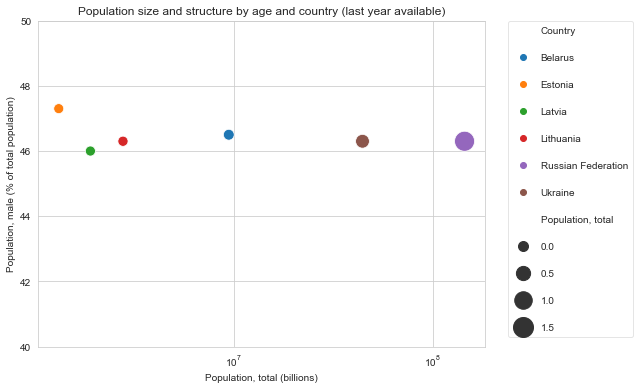

In [52]:
# Population size and structure
plt.figure(figsize=(8,6))
LE_plot = sns.scatterplot(x='Population, total', 
                y='Population, male (% of total population)',
                size = 'Population, total',sizes=(100,400),
                          hue=population.index, data=population)
plt.title("Population size and structure by age and country (last year available)")
plt.xlabel('Population, total (billions)')
plt.ylim(bottom=40,top=50)
LE_plot.set(xscale="log")
plt.legend(loc='upper left',ncol=1,framealpha=0.5,borderpad=0.5,labelspacing=1.8,bbox_to_anchor=(1.05,0.9,0.1,0.1),borderaxespad=0.05)


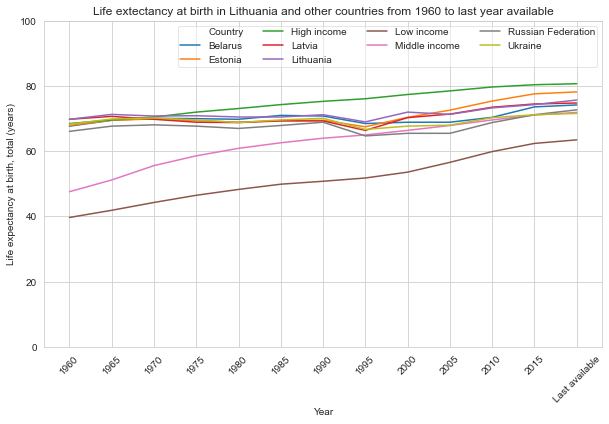

In [77]:
#Life expectancy
general_graph('Life expectancy at birth, total (years)','Life extectancy at birth in Lithuania and other countries from 1960 to last year available',0,100)

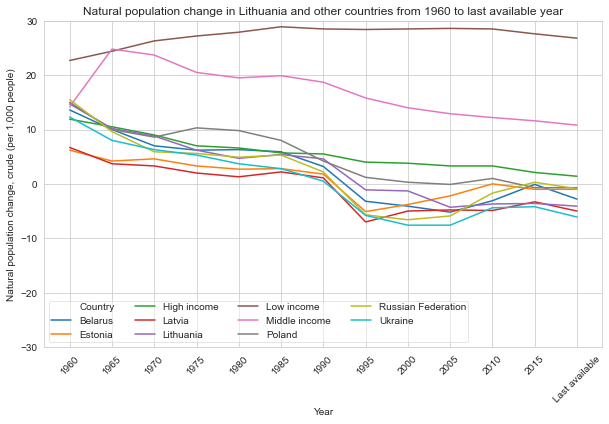

In [62]:
#Natural population change
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(x='Year',y='Value',hue='Country',data=nat_ch,ax=ax)
plt.title("Natural population change in Lithuania and other countries from 1960 to last available year")
plt.ylabel('Natural population change, crude (per 1,000 people)')
plt.xticks(rotation=45)
plt.ylim(bottom=-30,top=30)
plt.legend(loc=0,ncol=4,framealpha=0.5,borderpad=0.2)

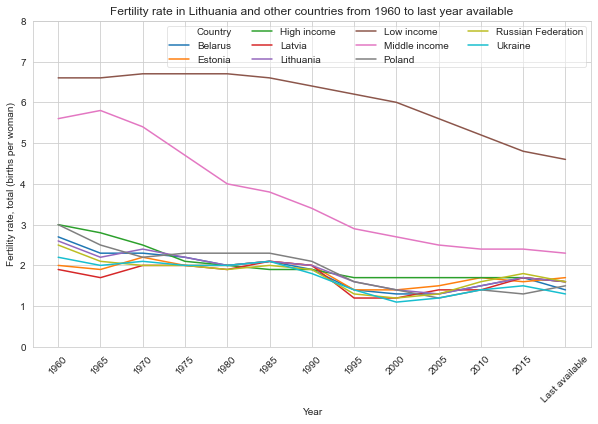

In [78]:
#Fertility
general_graph('Fertility rate, total (births per woman)','Fertility rate in Lithuania and other countries from 1960 to last year available',0,8)

## IV. What are the differences between men and woman in various countries?

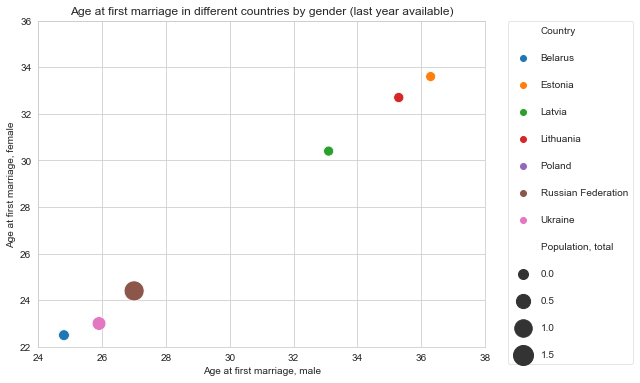

In [57]:
# Age at first marriage in different countries by gender (last available)
plt.figure(figsize=(8,6))
LE_plot = sns.scatterplot(x='Age at first marriage, male', 
                y='Age at first marriage, female',
                size = 'Population, total',sizes=(100,400),
                hue=age_at_mar.index, data=age_at_mar)
plt.title("Age at first marriage in different countries by gender (last year available)")
plt.ylim(bottom=22,top=36)
plt.xlim(left=24,right=38)
plt.legend(loc='upper left',ncol=1,framealpha=0.5,borderpad=0.5,labelspacing=1.8,bbox_to_anchor=(1.05,0.9,0.1,0.1),borderaxespad=0.05)


## V. How did differences between men and woman in Lithuania changed through years?